<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Diffusing-Digits---Generating-MNIST-Digits-from-noise-with-HuggingFace-Diffusers" data-toc-modified-id="Diffusing-Digits---Generating-MNIST-Digits-from-noise-with-HuggingFace-Diffusers-1">Diffusing Digits - Generating MNIST Digits from noise with HuggingFace Diffusers</a></span><ul class="toc-item"><li><span><a href="#Diffusion-Models---Quick-and-Dirty" data-toc-modified-id="Diffusion-Models---Quick-and-Dirty-1.1">Diffusion Models - Quick and Dirty</a></span><ul class="toc-item"><li><span><a href="#Diffusion-Models---Training" data-toc-modified-id="Diffusion-Models---Training-1.1.1">Diffusion Models - Training</a></span></li><li><span><a href="#Diffusion-Models---Sampling" data-toc-modified-id="Diffusion-Models---Sampling-1.1.2">Diffusion Models - Sampling</a></span></li></ul></li><li><span><a href="#Outline" data-toc-modified-id="Outline-1.2">Outline</a></span></li><li><span><a href="#Defining-Hyperparameters" data-toc-modified-id="Defining-Hyperparameters-1.3">Defining Hyperparameters</a></span></li><li><span><a href="#Preparing-MNIST-Dataset" data-toc-modified-id="Preparing-MNIST-Dataset-1.4">Preparing MNIST Dataset</a></span><ul class="toc-item"><li><span><a href="#Downloading-MNIST-with-HuggingFace-datasets" data-toc-modified-id="Downloading-MNIST-with-HuggingFace-datasets-1.4.1">Downloading MNIST with HuggingFace <code>datasets</code></a></span></li><li><span><a href="#Data-Preprocessing-and-Augmentation" data-toc-modified-id="Data-Preprocessing-and-Augmentation-1.4.2">Data Preprocessing and Augmentation</a></span></li></ul></li><li><span><a href="#Creating-the-Diffusion-Model" data-toc-modified-id="Creating-the-Diffusion-Model-1.5">Creating the Diffusion Model</a></span><ul class="toc-item"><li><span><a href="#U-Net-for-MNIST" data-toc-modified-id="U-Net-for-MNIST-1.5.1">U-Net for MNIST</a></span></li><li><span><a href="#Noise-Scheduler" data-toc-modified-id="Noise-Scheduler-1.5.2">Noise Scheduler</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-1.5.3">Optimizer</a></span></li><li><span><a href="#Learning-Rate-Scheduler" data-toc-modified-id="Learning-Rate-Scheduler-1.5.4">Learning Rate Scheduler</a></span></li></ul></li><li><span><a href="#Training-the-Model" data-toc-modified-id="Training-the-Model-1.6">Training the Model</a></span><ul class="toc-item"><li><span><a href="#Creating-and-Running-Training-Loop" data-toc-modified-id="Creating-and-Running-Training-Loop-1.6.1">Creating and Running Training Loop</a></span></li></ul></li><li><span><a href="#Create-a-sampling-function" data-toc-modified-id="Create-a-sampling-function-1.7">Create a sampling function</a></span></li><li><span><a href="#Sample-some-good-looking-digits!" data-toc-modified-id="Sample-some-good-looking-digits!-1.8">Sample some good looking digits!</a></span></li></ul></li></ul></div>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/st-howard/blog-notebooks/blob/main/MNIST-Diffusion/Diffusion%20Digits%20-%20Generating%20MNIST%20Digits%20from%20noise%20with%20HuggingFace%20Diffusers.ipynb)

# Diffusing Digits - Generating MNIST Digits from noise with HuggingFace Diffusers

Diffusion models have become the state of the art generative model by learning how to progressively remove "noise" from a randomly generated noise field until the sample matches the training data distribution. Diffusion models are a fundamental part of several noteworthy text to image models, including Imagen, DALLE-2, and Stable Diffusion. However, they are capabilities beyond text to image generation and are applicable to a large variety of generative tasks.

Here a minimal diffusion model is trained on the iconic [MNIST Digits](http://yann.lecun.com/exdb/mnist/) database using several [HuggingFace](https://huggingface.co/) libraries. The flow follows that of the [example](https://github.com/huggingface/diffusers/blob/main/docs/source/training/overview.mdx) HuggingFace notebook for unconditional image generation. I chose HuggingFace libraries for the implementation to learn their framework and I found that they were a nice balance between coding everything up in raw PyTorch (as was done in [HuggingFace annotated diffusion blog post](https://huggingface.co/blog/annotated-diffusion)) and tailored implementations such as Phil Wang's [denoising-diffusion-pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch).

## Diffusion Models - Quick and Dirty

Conceptually, diffusion models are built upon a series of noising and denoising steps. In the noising process, random Gaussian noise is iteratively added to data (typically an image but can be any numeric datatype). After many steps of adding noise, the original data becomes indistinguishable from Gaussian noise. This noising process is going from __right to left__ in the below figure from the [Denoising Diffusion Probabilistic Models paper](https://arxiv.org/abs/2006.11239) (often referred to as DDPM). In practice, getting from the original data to the step $t$ of the noising process can be done in one go based upon convenient properties of Gaussians.

![Diffusion Process](https://huggingface.co/blog/assets/78_annotated-diffusion/diffusion_figure.png)

The real juice of diffusion models is the denoising process. In the figure above, each denoising step (__left to right__ in above figure), attempts to remove the noise added from previous step. Given noisy data, the diffusion model tries to predict the noise present in the data (slightly different to the above depiction which shows the model learning the conditional probability distribution $p(x_{t-1} | x_t)$). This noise is iteratively removed until the denoised data, which by characteristic of the training distribution, is left.

Diffusion models can be broken down into two algorithms, one for training and one for sampling.

### Diffusion Models - Training
The training algorithm is relatively simple and follow the steps
- Take data from training distribution
- Randomly select a step within the noising/denoising process
- Sample random Gaussian noise with zero mean and unit variance
- Take noise field and data from training distribution and noise it to selected step from noising process.
- Predict the noise present in the noisy data
- Update model based upon mean squared error of actual noise and predicted noise

Which is shown in the psuedocode from the [Ho et. al paper](https://arxiv.org/abs/2006.11239).

![Training Pseudocode](https://huggingface.co/blog/assets/78_annotated-diffusion/training.png)

### Diffusion Models - Sampling
With a model that takes a noisy image and predicts the noise given the step in the noising chain, can iteratively denoise the data with the following steps
- Generate the fully noised data at last step $T$
- For each step in the chain, predict the noise in the image and remove some fraction of it.

Which is shown in the pseudocode

![Sampling Psuedocode](https://huggingface.co/blog/assets/78_annotated-diffusion/sampling.png)

There are details about noise and learning rate schedules which were omitted from the above, but covered in the [annotated diffusion blog post](https://huggingface.co/blog/annotated-diffusion)

##  Outline

In creating a diffusion model with HuggingFace, I found there to be __4__ main stages after choosing the hyperparameters, each with defined subtasks. I've shown an outline below

0. Defining Hyperparameters
1. Preparing Dataset
    * Downloading MNIST with HuggingFace `datasets`
    * Data preprocessing and augmentation
2. Creating the Diffusion Model
    * U-Net for MNIST
    * Noise Scheduler
    * Optimizer
    * Learning Rate Scheduler
3. Training the Model
    * HuggingFace Accelerator
    * Working with memory restrictions
    * Creating and running training script
4. Generating Images
    * Huggingface pipelines for inference

In [ ]:
%%capture
!pip install diffusers[training]==0.2.3
!pip install "ipywidgets>=7,<8"
!pip install datasets

In [ ]:
# Imports

# Pytorch
import torch
import torchvision

# HuggingFace
import datasets
import diffusers
import accelerate

# Training and Visualization
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import PIL

## Defining Hyperparameters

In the training config class shown below, I've chosen an image size of 32x32 instead of the default MNIST resolution of 28x28. This slight upscaling is in order to make the image width/height be a power of 2, i.e. $2^5$. In the default U-Net architecture, each downsampling layer reduces the width and height of the image by 2. Therefore after the three downsampling blocks I used in the U-Net, the output size will be 4x4x$N$, where $N$ is a configurable parameter of the model architecture. As the width and height of the image is reduced, the number of learned channels increases. So in the U-Net configured here, the bottleneck layer has dimension of 4x4x512.

The batch sizes chosen are done in order to comfortably fit on a 8 GB memory GPU. I find that training occupies approximately 4 GB of memory. Since one epoch contains all sixty thousand training examples, only a couple epochs are needed for the model to converge, with most of the learning being done within the first epoch.

The `lr_warmup_steps` is the number of mini-batches where the learning rate is increased until hitting the base learning rate listed in `learning_rate`. After the learning rate reaches this value, a cosine scheduler is used to slowly decrease the learning rate, as described in [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672).

In [ ]:
from dataclasses import dataclass

# Create configuration training class
@dataclass
class TrainingConfig:
  def __init__(self, image_size, train_batch_size, eval_batch_size, num_epochs, gradient_accumulation_steps, learning_rate, lr_warmpup_steps, mixed_precision, seed):
    self.image_size = image_size #Resize the digits to be a power of two
    self.train_batch_size = train_batch_size #number of training samples per batch
    self.eval_batch_size = eval_batch_size #number of evaluating samples per batch
    self.num_epochs = num_epochs
    self.gradient_accumulation_steps = gradient_accumulation_steps # gradients are accumulated over multiple steps before performing an update on param
    self.learning_rate = learning_rate
    self.lr_warmpup_steps = lr_warmpup_steps
    self.mixed_precision = mixed_precision # half precision floating point
    self.seed = seed

config = TrainingConfig(image_size=32,
                        train_batch_size=8,
                        eval_batch_size=8,
                        num_epochs=50,
                        gradient_accumulation_steps=1,
                        learning_rate =1e-4,
                        lr_warmpup_steps=500,
                        mixed_precision='fp16',
                        seed=0
                        )

## Preparing MNIST Dataset

### Downloading MNIST with HuggingFace `datasets`

HuggingFace has almost ten thousand dataset for download, which can be searched from the [datasets tab](https://huggingface.co/datasets) of their website. They can be downloaded with their `datasets` python library and the [`load_dataset()`](https://huggingface.co/docs/datasets/loading) function.

If not specified, the data will be downloaded to the `~/.cache` directory. If you want to put the files in another location, either specify the `data_dir` optional argument or change the environment variable `HF_DATASETS_CACHE` to the desired path.

Here MNIST digits are loaded into a `Dataset` object, where metadata, labels, and images can be accessed in a manner similar to python dictionaries.

In [ ]:
mnist_dataset = datasets.load_dataset('mnist', split='train')
type(mnist_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


datasets.arrow_dataset.Dataset

The dataset object is conveniently accessible with methods similar to a python dictionary

In [ ]:
idx = []
for i,image in enumerate(mnist_dataset):
  if image["label"] == 8:
    idx.append(i)
new_dataset = mnist_dataset.select(idx)
mnist_dataset = new_dataset

In [ ]:
len(mnist_dataset)

5851

In [ ]:
# mnist_dataset[0]["image"].resize((256, 256)).show()
print("Image Size:", mnist_dataset[0]["image"].size)
print("Digit is labelled:", mnist_dataset[0]['label'])

Image Size: (28, 28)
Digit is labelled: 8


### Data Preprocessing and Augmentation

As downloaded, the MNIST dataset contains 60,000 PIL images with pixel values in the range of $[0,255]$. The data must be scaled, resized, and turned into a tensor for ingestion by a PyTorch model. These transformations can be handled by torchvision's transforms library. Transform objects can be sequentially listed in a Compose constructor, which will apply then apply the transformations when an image is passed as an argument.

Three transforms are used. The first transforms the image to 32x32, in order to for the image width/height to be a power of two. The second transform turns the PIL image to a PyTorch tensor. When converting to a PyTorch tensor, the pixel range is transformed from $[0,255]$ to $[0,1]$. However, for the diffusion model the required pixel value range needs to be $[-1,1]$ since the Gaussian noise is zero mean, unit variance. Therefore, a lambda function is used to define a transform from $[0,1]$ to $[-1,1]$.

The `Datasets` object has a method `set_transform()` which applies a function which takes the dataset object as an argument. Here the method is used to apply the torchvision transforms to the MNIST dataset.

In [ ]:
def transform(dataset):
    preprocess = torchvision.transforms.Compose( # create pipeline
        [
            torchvision.transforms.Resize(
                (config.image_size, config.image_size)),  # resize image to 32x32
            torchvision.transforms.ToTensor(),            # change pixels into range [0,1]
            torchvision.transforms.Lambda(lambda x: 2*(x-0.5)), # change pixels into range [-1,1]
        ]
    )
    images = [preprocess(image) for image in dataset["image"]]
    return {"images": images}

In [ ]:
mnist_dataset.reset_format()
mnist_dataset.set_transform(transform) # apply transformation to the dataset

Once the dataset has been prepared with the proper transformers, it is ready to be passed directly into a PyTorch DataLoader.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size = config.train_batch_size,
    shuffle = True,
)

## Creating the Diffusion Model

### U-Net for MNIST

The workhorse of the denoising diffusion model is a U-Net, which is predicts the noise present in the input image conditioned on the step in the noising process. HuggingFace's Diffusers library has default a [U-Net class](https://huggingface.co/docs/diffusers/api/models#diffusers.UNet2DModel) which creates a PyTorch model based upon the input values. Here the input and output channels are set to one since the image is black and white. The rest of the parameters mirror the choices found in the example notebook from HuggingFace.

In [ ]:
def create_model():
  model = diffusers.UNet2DModel(
      sample_size=config.image_size,
      in_channels=1,  # grayscale images -> 1 input channel
      out_channels=1,
      layers_per_block=2, # each block of the upsampling and downsampling paths has 2 layers
      block_out_channels=(32,64, 128,256), # number of features are learned by the blocks of the downsampling paths
      down_block_types=(  #types of blocks used in the downsampling path
          "DownBlock2D",  #reduce the image size by extracting features and shrinking spatial dimensions.
          "DownBlock2D",
          "AttnDownBlock2D", #attention mechanism, which allows the model to focus on important parts of the image
          "DownBlock2D",
      ),
      up_block_types=( ##types of blocks used in the upsampling path
          "UpBlock2D",
          "AttnUpBlock2D",
          "UpBlock2D",
          "UpBlock2D",
      ),
  )
  return model

Check that the input image to the model and the output have the same shape

In [ ]:
# unsqueeze(0): create a new dimension to the image tensor at index (0)
# input shape (batch_size, channels, height, width)
# batch size = 1: represents a single image in a batch
sample_image = mnist_dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 1, 32, 32])


In [ ]:
model = create_model()
print('Output shape:', model(sample_image, timestep=0)["sample"].shape)

Output shape: torch.Size([1, 1, 32, 32])


In [ ]:
model(sample_image, timestep=1)

{'sample': tensor([[[[-1.5972e-01, -1.8180e-01, -2.5941e-01,  ..., -4.5678e-01,
            -5.2664e-01, -6.4725e-02],
           [ 1.3063e-01,  1.3085e-01,  1.7707e-02,  ..., -6.0721e-02,
            -4.1576e-01, -1.4204e-01],
           [-4.7662e-02, -2.9035e-02, -7.4638e-04,  ..., -4.9150e-02,
            -4.4058e-01, -9.7769e-02],
           ...,
           [-7.1588e-02, -1.2208e-01, -6.0993e-02,  ..., -3.5058e-02,
            -2.9711e-01, -9.4537e-02],
           [-2.7233e-02, -2.2883e-02,  1.1340e-01,  ..., -9.3958e-02,
            -3.2381e-01, -1.5772e-01],
           [ 8.8786e-02, -8.2847e-02,  3.1719e-04,  ..., -1.3105e-01,
            -2.3933e-01, -1.8133e-01]]]], grad_fn=<ConvolutionBackward0>)}

### Noise Scheduler

In diffusion models, the noise is added to images dependent on the step within noising/denoising process. In the original [DDPM paper](https://arxiv.org/abs/2006.11239), the strength of the noise added to the image (i.e. the variance of the zero mean Gaussian) increased linearly with time steps. The Diffusers library has a [noise scheduler object](https://huggingface.co/docs/diffusers/v0.3.0/en/api/schedulers#diffusers.DDPMScheduler) which handles the amount of noise to be added for a given step. The default values for noise are taken from the DDPM paper, but there are optional arguments to change the starting and ending noise strength, along with the how the noise changes with across steps.

In [ ]:
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=200, tensor_format='pt') # linear schedule

We can take a digit and use the scheduler object to add noise. Below is the

Original Digit


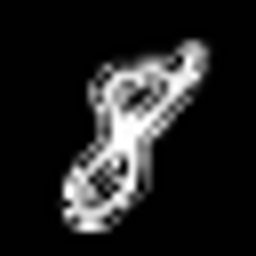

In [ ]:
print("Original Digit")
torchvision.transforms.ToPILImage()(sample_image.squeeze(1)).resize((256,256))

Fully Noised Digit


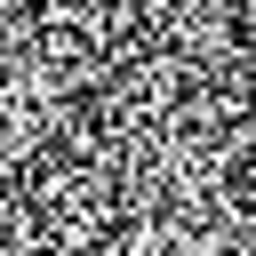

In [ ]:
noise = torch.randn(sample_image.shape) # random image of normal distribution
timesteps = torch.LongTensor([199]) #the last timestep that we want to add noise of the diffusion process
noisy_image = noise_scheduler.add_noise(sample_image,noise,timesteps)

print("Fully Noised Digit")
torchvision.transforms.ToPILImage()(noisy_image.squeeze(1)).resize((256,256))

### Optimizer

Let's have the U-Net can learn with the [AdamW optimizer](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html).

In [ ]:
# AdamW: A variant of Adam that decouples the weight decay (L2 regularization) from the gradient update
optimizer = torch.optim.AdamW(model.parameters(),lr=config.learning_rate)

### Learning Rate Scheduler

As mentioned previously, in [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672), they find a learning rate schedule which first warmups for a fixed number of steps and then follows a cosine schedule thereafter to be effective in training the model. The diffusers library has a [method](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.get_cosine_schedule_with_warmup) which creates a PyTorch learning rate scheduler which follows the advice given in this paper.

In [ ]:
# Cosine learning rate scheduler

lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmpup_steps, #500
    num_training_steps=(len(train_dataloader)*config.num_epochs),
)

## Training the Model

### Creating and Running Training Loop

The training function first creates a HuggingFace [`accelerator`](https://huggingface.co/docs/accelerate/v0.12.0/en/package_reference/accelerator#accelerator) object. The purpose of the `accelerator` object is to automatically handle device assignment for PyTorch objects when training on multiple devices and to make the code portable when running in multiple setups. Once created, the `accelerator` has a method `prepare` which takes all of the model/U-Net, optimizer, dataloader, and learning rate scheduler and automatically detects the correct device(s) and makes the appropriate `.to()` assignments.

After those objects are "prepared", the training has an outer `for` loop for each epoch and an inner `for` loop for each mini-batch. In each mini-batch, a set of digits is taken from the dataset. Random noise with the same size of the minibatch is then sampled. Then, for each image in the minibatch, a random step in the noising process is (uniformly) selected. Noise is then added to each image based upon the randomly sampled noise and the randomly selected step. The U-Net then predicts the noise added to the image conditioned on the selected step. A mean squared error loss is then calculated between the predicted noise and the actual noise added to the image. This loss is then used to update the weights for each mini-batch.  

In [ ]:
def train_loop(
        config,
        model,
        noise_scheduler,
        optimizer,
        train_dataloader,
        lr_scheduler):
    device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
    accelerator = accelerate.Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    device = accelerator.device

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader),
                            disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images'].to(device)

            noise = torch.randn(clean_images.shape).to(device)
            batch_size = clean_images.shape[0]

            # Sample a set of random time steps for each image in mini-batch
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (batch_size,), device=noise_scheduler.alphas_cumprod.device)

            noisy_images=noise_scheduler.add_noise(clean_images, noise, timesteps).to(device)
            timesteps = timesteps.to(device)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images,timesteps)["sample"].to(device)
                loss = torch.nn.functional.mse_loss(noise_pred,noise).to(device)
                accelerator.backward(loss) # backpropagates the loss through the model to compute the gradients

                accelerator.clip_grad_norm_(model.parameters(),1.0).to(device)
                optimizer.step() # update the model's weights in the direction that minimizes the loss
                lr_scheduler.step() # adjusts the learning rate, should be decrease
                optimizer.zero_grad() # gradients are reset (set to zero) so that they don’t accumulate across batches or training steps.

            progress_bar.update(1)
            logs = {
                "loss" : loss.detach().item(),
                "lr" : lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)
    accelerator.unwrap_model(model)

Once the training loop set up, the function along with its arguments can be passed to the accelerate library's [`notebook launcher`](https://huggingface.co/docs/accelerate/v0.12.0/en/basic_tutorials/notebook#using-the-notebooklauncher) to train within the notebook.

In [ ]:
config = TrainingConfig(image_size=32,
                        train_batch_size=64,
                        eval_batch_size=64,
                        num_epochs=100,
                        gradient_accumulation_steps=1,
                        learning_rate =1e-4,
                        lr_warmpup_steps=500,
                        mixed_precision='fp16',
                        seed=0
                        )
model = create_model()

train_dataloader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size = config.train_batch_size,
    shuffle = True,
)
optimizer = torch.optim.AdamW(model.parameters(),lr=config.learning_rate)
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=200, tensor_format='pt')

lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmpup_steps, #500
    num_training_steps=(len(train_dataloader)*config.num_epochs),
)

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

accelerate.notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the full model
model.save_pretrained("drive/MyDrive/PIMA/unet_model_4")

# Save only the weights (state_dict)
# torch.save(model.state_dict(), "drive/MyDrive/PIMA/unet_model_weights_2.pth")

In [ ]:
from diffusers import UNet2DModel

# Load the model
model1 = UNet2DModel.from_pretrained("drive/MyDrive/PIMA/unet_model_1")
model2 = UNet2DModel.from_pretrained("drive/MyDrive/PIMA/unet_model_2")

## Create a sampling function

Once the model has been trained, we can sample the model to create digits. Or more accurately create a sample which is within the learned distribution of the training samples, since some generated samples look like an alien's numbering system, a mish-mash of the numbers 0-9.

To sample images, the Diffusers library has several pipelines. However, [I found that these pipelines don't work for single channel images](https://github.com/huggingface/diffusers/issues/488). So I created a small function which samples the images, with an optional argument for saving off each step. Importantly, the function needs to have a `torch.no_grad()` decorator so the model doesn't accumulate the history of the forward passes.

In [ ]:
@torch.no_grad()
def sample(unet, scheduler,seed,save_process_dir=None):
    torch.manual_seed(seed)

    if save_process_dir:
        if not os.path.exists(save_process_dir):
            os.mkdir(save_process_dir)

    scheduler.set_timesteps(1000)
    image=torch.randn((1,1,32,32)).to(model.device)
    num_steps=max(noise_scheduler.timesteps).numpy()

    for t in noise_scheduler.timesteps:
        model_output=unet(image,t)['sample'] # noise_pred
        # print("Model Output \n",model_output)
        image=scheduler.step(model_output,int(t),image,generator=None)['prev_sample']
        # print("New image",image)
        if save_process_dir:
            save_image=torchvision.transforms.ToPILImage()(image.squeeze(0))
            save_image.resize((256,256)).save(
                os.path.join(save_process_dir,"seed-"+str(seed)+"_"+f"{num_steps-t.numpy():03d}"+".png"),format="png")

    return torchvision.transforms.ToPILImage()(image.squeeze(0))

## Sample some good looking digits!

Some samples look quit good...

In [ ]:
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=200, tensor_format='pt')

In [ ]:
test_image1=sample(model1,noise_scheduler,2)
test_image1.resize((265,256)).show()
test_image2=sample(model2,noise_scheduler,2)
test_image2.resize((256,256))

In [ ]:
plt.imshow(test_image1)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()
plt.imshow(test_image2)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()

In [ ]:
test_image1=sample(model1,noise_scheduler,5)
test_image1.resize((256,256))

test_image2=sample(model2,noise_scheduler,5)
test_image2.resize((256,256))

plt.imshow(test_image1)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()

plt.imshow(test_image2)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()

In [ ]:
test_image1=sample(model1,noise_scheduler,1991)
test_image1.resize((256,256))

test_image2=sample(model2,noise_scheduler,1991)
test_image2.resize((256,256))

plt.imshow(test_image1)
plt.axis("off")
plt.gray()
plt.show()

plt.imshow(test_image2)
plt.axis("off")
plt.gray()
plt.show()

But others aren't quite recognizable as a number, but look like they *could* be number if things went just slightly differently...

In [ ]:
test_image1=sample(model1,noise_scheduler,2022)
test_image1.resize((256,256))

test_image2=sample(model2,noise_scheduler,2022)
test_image2.resize((256,256))

plt.imshow(test_image1)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()

plt.imshow(test_image2)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()

In [ ]:
test_image1=sample(model1,noise_scheduler,42)
test_image1.resize((256,256))

test_image2=sample(model2,noise_scheduler,42)
test_image2.resize((256,256))

plt.imshow(test_image1)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()

plt.imshow(test_image2)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()

In [ ]:
test_image1=sample(model1,noise_scheduler,60)
test_image1.resize((256,256))

test_image2=sample(model2,noise_scheduler,60)
test_image2.resize((265,256))

plt.imshow(test_image1)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()

plt.imshow(test_image2)
plt.axis("off")  # Hide axes
plt.gray()
plt.show()